In [1]:
%matplotlib inline
from fns import *
from syntheticdata import synthetic_generation

In [2]:
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2, summaries=True):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,nz,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """
    
    logging.info("Layers: {layers}, FeaturesRoot: {features_root}, ConvolutionSize: {filter_size}*{filter_size}*{filter_size}, PoolingSize: {pool_size}*{pool_size}*{pool_size}"\
                 .format(layers=layers, features_root=features_root, filter_size=filter_size, pool_size=pool_size))
    
    in_node = x
    batch_size = tf.shape(x)[0] 
    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    in_size = 144
    size = in_size

   
    # down layers
    with tf.name_scope('going_down'):
        for layer in range(0, layers):
            with tf.name_scope('layer_down_%d'%layer):
                features = 2**layer*features_root
                stddev = 1 / (filter_size**3 * features)
                if layer == 0:
                    w1 = weight_variable([filter_size, filter_size, filter_size, channels, features], stddev)
                else:
                    w1 = weight_variable([filter_size, filter_size, filter_size, features//2, features], stddev)
                w2 = weight_variable([filter_size, filter_size, filter_size, features, features], stddev)
                b1 = bias_variable([features])
                b2 = bias_variable([features])
                
                conv1 = conv3d(in_node, w1, keep_prob)
                tmp_h_conv = tf.nn.elu(conv1 + b1)
                conv2 = conv3d(tmp_h_conv, w2, keep_prob)
                dw_h_convs[layer] = tf.nn.elu(conv2 + b2)
                
                logging.info("Down Convoltion Layer: {layer} Size: {size}".format(layer=layer,size=dw_h_convs[layer].get_shape()))
                
                weights.append((w1, w2))
                biases.append((b1, b2))
                convs.append((conv1, conv2))

                size -= 4    
                if layer < layers-1:
                    pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                    in_node = pools[layer]
                    size /= 2    
        
    in_node = dw_h_convs[layers-1]
        
    # up layers
    with tf.name_scope('going_up'):
        for layer in range(layers-2, -1, -1):   
            with tf.name_scope('layer_up_%d'%layer):
                features = 2**(layer+1)*features_root
                stddev = 1 / (filter_size**3 * features)

                wd = weight_variable_devonc([pool_size, pool_size, pool_size, features//2, features], stddev)
                bd = bias_variable([features//2])
                h_deconv = tf.nn.elu(deconv3d(in_node, wd, pool_size) + bd)
                h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)    
                deconv[layer] = h_deconv_concat

                w1 = weight_variable([filter_size, filter_size, filter_size, features, features//2], stddev)
                w2 = weight_variable([filter_size, filter_size, filter_size, features//2, features//2], stddev)
                b1 = bias_variable([features//2])
                b2 = bias_variable([features//2])

                conv1 = conv3d(h_deconv_concat, w1, keep_prob)
                h_conv = tf.nn.elu(conv1 + b1)
                conv2 = conv3d(h_conv, w2, keep_prob)
                in_node = tf.nn.elu(conv2 + b2)
                up_h_convs[layer] = in_node
                
                logging.info("Up Convoltion Layer: {layer} Size: {size}".format(layer=layer,
                                                                                size=tf.shape(dw_h_convs[layer])))
                
                weights.append((w1, w2))
                biases.append((b1, b2))
                convs.append((conv1, conv2))

                size *= 2
                size -= 4

    # Output Map
    with tf.name_scope('output_map'):
        #stddev = 1 / (features_root)
        weight = weight_variable([1, 1, 1, features_root, 1], stddev)
        bias = bias_variable([1])
        conv = conv3d(in_node, weight, tf.constant(1.0))
        output_map = tf.nn.sigmoid(conv + bias)
        up_h_convs["out"] = output_map
        logging.info("Output map shape {size}, offset {offset}".format(size=output_map.get_shape(), offset=int(in_size-size)))

        if summaries:
#             for i, (c1, c2) in enumerate(convs):
#                 tf.summary.image('summary_conv_%03d_01'%i, get_image_summary(c1))
#                 tf.summary.image('summary_conv_%03d_02'%i, get_image_summary(c2))

#             for k in pools.keys():
#                 tf.summary.image('summary_pool_%03d'%k, get_image_summary(pools[k]))

#             for k in deconv.keys():
#                 tf.summary.image('summary_deconv_concat_%03d'%k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%03d"%k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s"%k + '/activations', up_h_convs[k])

        variables = []
        for w1,w2 in weights:
            variables.append(w1)
            variables.append(w2)

        for b1,b2 in biases:
            variables.append(b1)
            variables.append(b2)
        
        variables.append(weight)
        variables.append(bias)
        
    return output_map, variables, int(in_size - size)

In [3]:
class Unet(object):
    """
    A unet implementation

    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """

    def __init__(self, channels=1, n_class=1, cost="dice_coefficient", cost_kwargs={}, **kwargs):
        tf.reset_default_graph()

        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)

        self.x = tf.placeholder(tf.float32, shape=[None, None, None, None, channels], name='data')
        self.y = tf.placeholder(tf.float32, shape=[None, None, None, None, n_class], name='target')
        self.keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)

        logits, self.variables, self.offset = create_conv_net(self.x, self.keep_prob, channels, n_class, **kwargs)
        logging.info("Actual Output Shape: {}".format(logits.get_shape()))
        logging.info("Desired Output Shape: {}".format(self.y.get_shape()))

        self.logits = logits
        self.predicter = self.logits
        self.predicter_label = tf.cast(self.predicter >= 0.5, tf.float32)
        self.correct_pred = tf.cast(
            tf.equal(tf.reshape(self.predicter_label, [-1, n_class]), tf.reshape(self.y, [-1, n_class])), tf.float32)
        self.cost = self._get_cost(self.logits, self.predicter, cost, cost_kwargs)
        self.gradients_node = tf.gradients(self.cost, self.variables)
        self.cross_entropy = tf.reduce_mean(
            cross_entropy(tf.reshape(self.y, [-1, n_class], name='cross_entro_label_reshape'),
                          tf.reshape(pixel_wise_softmax_2(logits), [-1, n_class], name='px_logit_reshape')))
        self.accuracy = tf.reduce_mean(self.correct_pred)

    def _get_cost(self, logits, predicter, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are:
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """
        with tf.name_scope('cost_function'):
            logging.info('*' * 50)
            logging.info('getting cost')
            logging.info("Logits: {}".format(logits.get_shape()))
            logging.info("Y: {}".format(self.y.get_shape()))
            flat_logits = tf.reshape(logits, [-1, self.n_class], name='flat_logits_reshape')
            flat_predicter = tf.reshape(predicter, [-1, self.n_class], name='flat_predicter_reshape')
            flat_labels = tf.reshape(self.y, [-1, self.n_class], name='flat_labels_reshape')
            if cost_name == "cross_entropy":
                class_weights = cost_kwargs.pop("class_weights", None)

                if class_weights is not None:
                    class_weights = tf.constant(np.array(class_weights, dtype=np.float32))

                    weight_map = tf.multiply(flat_labels, class_weights, name='weightmap')
                    weight_map = tf.reduce_sum(weight_map, axis=1)

                    loss_map = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels)
                    weighted_loss = tf.multiply(loss_map, weight_map, name='weightloss')

                    loss = tf.reduce_mean(weighted_loss)

                else:
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                                                                  labels=flat_labels))
            elif cost_name == "dice_coefficient":
                intersection = tf.reduce_sum(flat_predicter * flat_labels)
                union = tf.reduce_sum(flat_predicter) + tf.reduce_sum(flat_labels)
                loss = 1 - 2 * intersection / union

            else:
                raise ValueError("Unknown cost function: " % cost_name)

            regularizer = cost_kwargs.pop("regularizer", None)
            if regularizer is not None:
                regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
                loss += (regularizer * regularizers)

        return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data

        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, nz, channels]
        :returns prediction: The unet prediction Shape [n, px, py, pz, labels] (px=nx-self.offset/2)
        """

        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)

            # Restore model weights from previously saved model
            self.restore(sess, model_path)

            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], self.n_class))
            prediction = sess.run(self.predicter_label, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})

        return prediction

    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint

        :param sess: current session
        :param model_path: path to file system location
        """

        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path

    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint

        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """

        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

In [4]:



def get_image_summary(img, idx=0):
    """
    Make an image summary for 4d tensor image with index idx
    """
    
    V = tf.slice(img, (0, 0, 0, idx), (1, -1, -1, 1))
    V -= tf.reduce_min(V)
    V /= tf.reduce_max(V)
    V *= 255
    
    img_w = tf.shape(img)[1]
    img_h = tf.shape(img)[2]
    V = tf.reshape(V, tf.stack((img_w, img_h, 1)))
    V = tf.transpose(V, (2, 0, 1))
    V = tf.reshape(V, tf.stack((-1, img_w, img_h, 1)))
    return V

## setting up the unet

In [5]:
net = Unet(channels=1, 
           n_class=1, 
           layers=4, 
           pool_size=2,
           features_root=16, summaries=True
          )

## training

In [19]:
Num_Training = 10
Num_Validation = 2
Num_Testing = 2

training_array = []
validation_array = []
testing_array = []

LOADPATH = "/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00_synthetic/numpy/"
for num in range(Num_Training):
    case = np.load(LOADPATH + "training_case{}.npy".format(num+1))
    labelmap = np.load(LOADPATH + "training_labelmap{}.npy".format(num+1))
    training_array.append([case, labelmap])

for num in range(Num_Validation):
    case = np.load(LOADPATH + "validation_case{}.npy".format(num+1))
    labelmap = np.load(LOADPATH + "validation_labelmap{}.npy".format(num+1))
    validation_array.append([case, labelmap])
    
for num in range(Num_Testing):
    case = np.load(LOADPATH + "testing_case{}.npy".format(num+1))
    labelmap = np.load(LOADPATH + "testing_labelmap{}.npy".format(num+1))
    testing_array.append([case, labelmap])    
    
    

In [20]:
# data_provider = ImageDataProvider(array=False)
# trainer = Trainer(net, batch_size=3, optimizer="adam")
# path = trainer.train(data_provider, 
#                      "./unet_trained",
#                      restore=True,
#                      training_array = training_array,
#                      validation_array = training_array[:10],
#                      testing_array = None,
#                      training_iters=182, 
#                      epochs=50, 
#                      dropout=0.75, 
#                      display_step=1)

### Predict

In [21]:
testingdata_provider = ImageDataProvider(array=True)
testing_data, label_data = testingdata_provider(testing_array,"testing")
# testing_data = provider._load_data_and_label(provider.training_data_files)
testing_data.shape

(1, 148, 148, 148, 1)

In [20]:
i = 2
prediction = net.predict("./unet_trained/model 35.cpkt", testing_data)[0][:,:,:,0]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 35.cpkt


In [21]:
print(np.unique(prediction, return_counts=True))
print(prediction.shape)

(array([ 0.,  1.], dtype=float32), array([203854,  12146]))
(60, 60, 60)


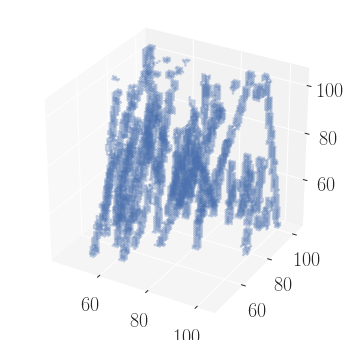

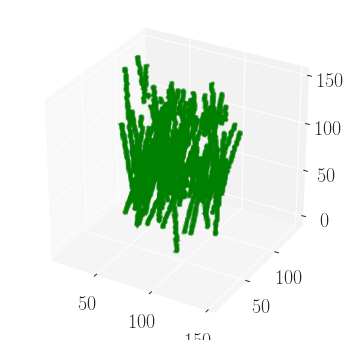

In [25]:
%matplotlib inline
xs,ys,zs = np.where(prediction == 1)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs+44, ys+44, zs+44, marker='o', alpha=0.3, s=5)
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = np.where(label_data[0, ...,0] == 1)
ax.scatter(xs, ys, zs, marker='o',color='g', alpha=0.3, s=5)
plt.show()

## predict on real data

In [26]:
provider = ImageDataProvider()
testing_data, label_data = provider._load_data_and_label(provider.testing_data_files,3)
testing_data.shape

Number of training data used: 37
Number of validation data used: 7
Number of testing data used: 3


(3, 148, 148, 148, 1)

In [29]:
i = 2
prediction = net.predict("./unet_trained/model 44.cpkt", testing_data[i][np.newaxis,...])[0][:,:,:,0]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 44.cpkt


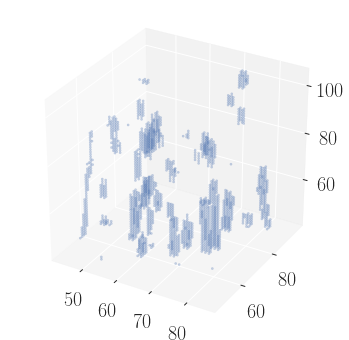

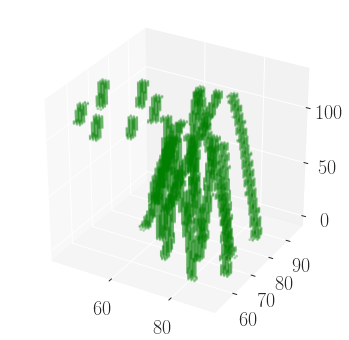

In [30]:
%matplotlib inline
xs,ys,zs = np.where(prediction == 1)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs+44, ys+44, zs+44, marker='o', alpha=0.3, s=5)
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = np.where(label_data[i, ...,0] == 1)
ax.scatter(xs, ys, zs, marker='o',color='g', alpha=0.3, s=5)
plt.show()